# Описание проекта

* Отрасль: нефтедобыча


* Цель: определить наиболее выгодный регион разработки.
* Процесс выбора регионов для разработки:
    - В избранном регионе собирают характеристики для скважин: **качество нефти и объём её запасов**;
    - Строят **модель для предсказания объёма запасов** в новых скважинах;
    - Выбирают скважины с **самыми высокими оценками значений**;
    - Определяют регион с **максимальной суммарной прибылью** отобранных скважин.
 
 
* Данные предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны.
* Описание данных:
    - id — уникальный идентификатор скважины;
    - f0, f1, f2 — три признака месторождения (вероятно это характеристики качества нефти и параметры, характеризующие размер месторождения). Заказчик, возможно, не желает раскрывать суть данных характеристик, но говорит об их значимости при построении моделей;
    - product — объём запасов в скважине (тыс. баррелей).
  
  
* Задачи:
    - Построить модели (линейной регрессии) предсказания объемов запасов;
    - На основе предсказаний модели оценить прибыль с учетом заданных параметров
    - Оценить риски разработки каждого из регионов
    - Выбрать наиболее выгодный с точки зрения прибыльности регион разработки
    
    
* Дополнительные условия:
    - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
    - При разведке региона **исследуют 500 точек**, из которых с помощью машинного обучения **выбирают 200 лучших** для разработки.
    - **Бюджет на разработку** скважин в регионе — **10 млрд рублей**.
    - При нынешних ценах **один баррель сырья приносит 450 рублей дохода**. 
    - После оценки рисков **нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%**. Среди них выбирают регион с наибольшей средней прибылью.

# Импорт необходимых библиотек и функций

In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from scipy.stats import normaltest

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Загрузка и подготовка данных

## Загрузка и предобработка

In [2]:
# Выгружаем данные с помощью цикла
# На кажлом шаге считываем 1 фал и сохраняем в отдельную переменную
for i in range(3):
    file_name = 'geo_data_' + str(i) + '.csv'
    data_name = 'df_' + str(i)
    try:
        print(data_name)
        globals()[data_name] = pd.read_csv(file_name)
        display(globals()[data_name].head())
        print('_'*100)
    except:
        file_path = '/datasets/'
        print(data_name)
        globals()[data_name] = pd.read_csv(file_path + file_name)
        display(globals()[data_name].head())
        print('_'*100)

df_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


____________________________________________________________________________________________________
df_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


____________________________________________________________________________________________________
df_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


____________________________________________________________________________________________________


In [3]:
# Создаем функцию для сбора описательной статистики и выявления проблем с данными
def data_description(data):
# Создаем таблицу для сохранения данных
    description_table = pd.DataFrame(index = data.columns)
# Группируем характеристики по типам данных    
    object_columns = data.dtypes[(data.dtypes == 'object')].index.tolist()
    float_int_columns = data.columns.drop(object_columns)
# Общие сведения о таблице    
    print(f'Размер таблицы {data.shape}')
    print()
    print(f'Пропущенные значения: {data.isna().sum().sum()} штук ({data.isna().sum().sum()/data.count().sum():.2%})')
    print()
    print(f'Явные дубликаты: {data.duplicated().sum()} штук ({data.duplicated().sum():.2%})')
# Заполняем таблицу с описательными данными
    description_table['type'] = data.dtypes # Тип данных столбца
    description_table['gaps_count'] = data.isna().sum() # Число пропусков в столбце
    description_table['gaps_share'] = data.isna().sum()/len(data) # Доля этих пропусков в столбце
    
    # Описательные статистики числовых данных
    description_table = description_table.join(data.loc[:,  float_int_columns].describe().T) 
    
    # Выявление неявных дубликатов в файлах с текстовой информацией
    for object_column in object_columns:
        description_table.loc[object_column, 'implicit_dups'] = data[object_column].str.lower().duplicated().sum()
        
    return description_table
    

In [4]:
data_description(df_0)

Размер таблицы (100000, 5)

Пропущенные значения: 0 штук (0.00%)

Явные дубликаты: 0 штук (0.00%)


,type,gaps_count,gaps_share,count,mean,std,min,25%,50%,75%,max,implicit_dups
id,object,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.0
f0,float64,0,0.0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331,NaN
f1,float64,0,0.0,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769,NaN
f2,float64,0,0.0,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790,NaN
product,float64,0,0.0,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347,NaN


In [5]:
data_description(df_1)

Размер таблицы (100000, 5)

Пропущенные значения: 0 штук (0.00%)

Явные дубликаты: 0 штук (0.00%)


,type,gaps_count,gaps_share,count,mean,std,min,25%,50%,75%,max,implicit_dups
id,object,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.0
f0,float64,0,0.0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755,NaN
f1,float64,0,0.0,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063,NaN
f2,float64,0,0.0,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721,NaN
product,float64,0,0.0,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408,NaN


In [6]:
data_description(df_2)

Размер таблицы (100000, 5)

Пропущенные значения: 0 штук (0.00%)

Явные дубликаты: 0 штук (0.00%)


,type,gaps_count,gaps_share,count,mean,std,min,25%,50%,75%,max,implicit_dups
id,object,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0
f0,float64,0,0.0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262,NaN
f1,float64,0,0.0,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801,NaN
f2,float64,0,0.0,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402,NaN
product,float64,0,0.0,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838,NaN


**Краткий вывод по предобработке**:
* Пропусков в данных не обнаружено
* Явные дубликаты в данных не обнаружены
* Типы данных соответствуют смыслу характеристик
* В столбце **`id`** обнаружены **неявные дубликаты**. Однако если изучть информацию в данном столбце, то можно понять, что **маркировка** скважин **предполагает наличие строчных и заглавных букв**, поэтому не обращаем внимание на эти неявные дубликаты. **Это действительно разные скважины**.

## Подготовка данных к машинному обучению

In [7]:
rnd_st = 12345

In [8]:
"""
Функция на вход принимает аргумент: "data", куда передается датафрейм.
возвращает признаки и целевой признак.
"""
def features_target_split(data):
    
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']
    
    return features, target

In [9]:
"""
функция на вход принимает аргумент: "data", куда передается датафрейм.
возвращает выборки, тренировочнуюю и валидационную.
"""
def train_valid_split(data, test_size):
    
    features, target = features_target_split(data)
    
    (features_train, 
     features_valid, 
     target_train, 
     target_valid) = train_test_split(features, 
                                      target, 
                                      test_size = test_size, 
                                      random_state = rnd_st)
    
    return (features_train, 
            features_valid, 
            target_train, 
            target_valid)

In [10]:
def linear_model(data, residuals_hist = True):

    (features, 
     target) = features_target_split(data)
    
    (features_train, 
     features_valid, 
     target_train, 
     target_valid) = train_valid_split(data, 0.25)
    
    col_names = ['model', 
                 'predicted_mean_valid', 'rmse_valid', 'mae_valid', 'R2_valid', 
                 'predicted_mean_train', 'rmse_train', 'mae_train', 'R2_train']
    
    result = pd.DataFrame(columns = col_names)
    train_predictions_data = pd.DataFrame(index = features_train.index)
    valid_predictions_data = pd.DataFrame(index = features_valid.index)
    
    model = LinearRegression()
    model = model.fit(features_train, target_train)
    
    valid_predictions = model.predict(features_valid)
    predicted_mean_valid = valid_predictions.mean()
    rmse_valid = mean_squared_error(target_valid, valid_predictions) ** 0.5
    mae_valid = mean_absolute_error(target_valid, valid_predictions)
    R2_valid = model.score(features_valid, target_valid)
    
    train_predictions = model.predict(features_train)
    predicted_mean_train = train_predictions.mean()
    rmse_train = mean_squared_error(target_train, train_predictions) ** 0.5
    mae_train = mean_absolute_error(target_train, train_predictions)
    R2_train = model.score(features_train, target_train)
    
    valid_predictions_data = pd.Series(valid_predictions, index = features_valid.index)
    train_predictions_data = pd.Series(train_predictions, index = features_train.index)
    
    row = pd.DataFrame([[model, 
                         predicted_mean_valid, rmse_valid, mae_valid, R2_valid, 
                         predicted_mean_train, rmse_train, mae_train, R2_train]], columns = col_names)
    
    result = result.append([row], ignore_index = True)
    
    if residuals_hist == True:
        residuals_valid = target_valid - valid_predictions
        plt.figure(figsize=(5, 5))
        ax = sns.distplot(residuals_valid)
        plt.title('График распределения остатков (по валидационной выборке)')
        plt.xlabel('Остатки модели')
        plt.ylabel('Плотность распределения')
        plt.show()
        
        p_value = normaltest(residuals_valid).pvalue
        if (p_value < 0.05):
            print()
            print('Распределение остатков модели на валидационной выборке нельзя считать нормальным.')
        else:
            print("Распределение остатков модели на валидационной выборке можно считать нормальным.")
        
        
        residuals_train = target_train - train_predictions
        plt.figure(figsize=(5, 5))
        ax = sns.distplot(residuals_train)
        plt.title('График распределения остатков (по обучающей выборке)')
        plt.xlabel('Остатки модели')
        plt.ylabel('Плотность распределения')
        plt.show()
        
        p_value = normaltest(residuals_valid).pvalue
        if (p_value < 0.05):
            print()
            print('Распределение остатков модели на обучающей выборке нельзя считать нормальным.')
        else:
            print("Распределение остатков модели на обучающей выборке можно считать нормальным.")
        
    
    return result, valid_predictions_data, train_predictions_data

df_0


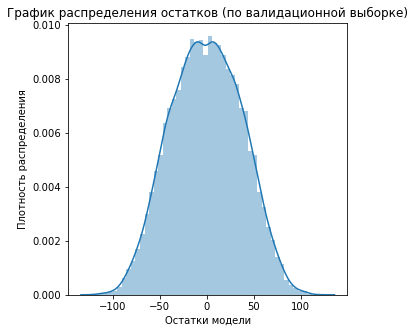


Распределение остатков модели на валидационной выборке нельзя считать нормальным.


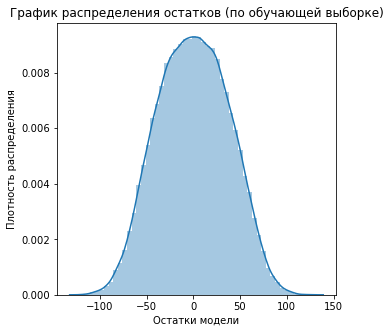


Распределение остатков модели на обучающей выборке нельзя считать нормальным.
____________________________________________________________________________________________________
df_1


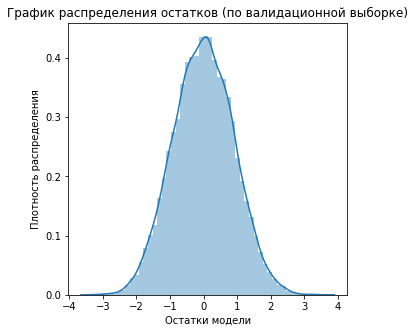


Распределение остатков модели на валидационной выборке нельзя считать нормальным.


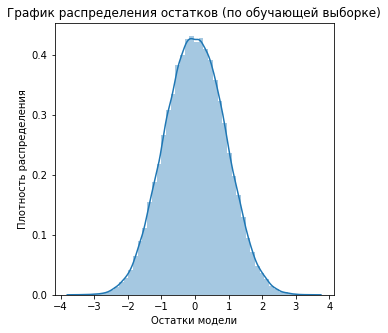


Распределение остатков модели на обучающей выборке нельзя считать нормальным.
____________________________________________________________________________________________________
df_2


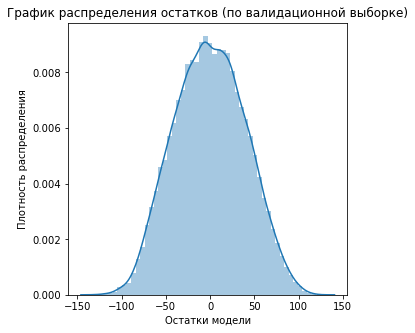


Распределение остатков модели на валидационной выборке нельзя считать нормальным.


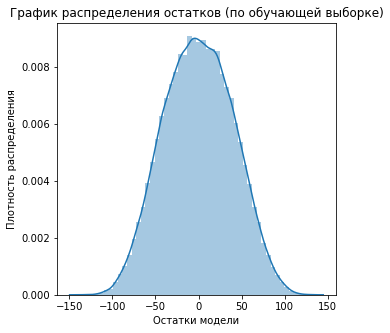


Распределение остатков модели на обучающей выборке нельзя считать нормальным.
____________________________________________________________________________________________________


In [11]:
# Вспомогательные списки
data_sets = [df_0, df_1, df_2]
data_names = ['df_0', 'df_1', 'df_2']
# Таблица с моделями и их характеристиками
result_models = pd.DataFrame()

# Создаем отдельные переменные для прогнозных значений и единую таблицу с характеристиками моделей
for i in range(0, len(data_sets)):
    print(data_names[i])
    (result_model_i, 
     globals()['valid_predictions_' + data_names[i]], 
     globals()['train_predictions_' + data_names[i]]) = linear_model(data_sets[i], residuals_hist = True)
    print('_'*100)
    globals()['valid_predictions_' + data_names[i]].columns = [data_names[i]]
    globals()['train_predictions_' + data_names[i]].columns = [data_names[i]]
    result_model_i.index = [data_names[i]]
    result_models = result_models.append(result_model_i)



In [12]:
result_models

,model,predicted_mean_valid,rmse_valid,mae_valid,R2_valid,predicted_mean_train,rmse_train,mae_train,R2_train
df_0,LinearRegression(),92.592568,37.579422,30.919601,0.279943,92.640468,37.729992,31.079961,0.274239
df_1,LinearRegression(),68.728547,0.893099,0.718766,0.999623,68.858955,0.889472,0.716844,0.999625
df_2,LinearRegression(),94.965046,40.029709,32.792652,0.205248,95.038589,40.064260,32.839411,0.196614


**Краткий вывод по моделям**:
* **Очень странными получились результаты для региона №2**. Очень высокий показатель детерминации.Возможно, какой-то из признаков объясняет всю вариацию в объемах месторождения. Данный факт следует проверить, например, путем оценки попарных коэффициентов корреляции.
* Во всех моделях остатки регрессии не распределены нормально. Этот факт, согласно теории вероятностей, указывает на то, что нужно с оторожностью относиться к пронозам этих моделей.

In [13]:
# Оценка попарных корреляций для данных по второму региону.
df_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


**Краткий вывод по модели для региона №2**:
* Как и предполагалось, признак **`f2` сильно коррелирует с объемами месторождения**. Поскольку мы не знаем природу этих показателей и особенностей регионов добычи, следует продолжать работу с этими данными. Однако в выводах стоит упомянуть об этом факте.

## Подготовка к расчету прибыли

In [14]:
# сохраним в переменные известные нам ключевые значения для расчетов
budget = 10*(10**9)
n_oil_fields = 500
n_best_oil_fields = 200
cost_per_one_best_oil_field = budget / n_best_oil_fields
barrel_profit = 450 * 1000
# посчитаем колличество баррелей необходимых для разработки
# одного месторождения и сохраним в переменную
barrels_minimum = cost_per_one_best_oil_field / barrel_profit

print('Безубыточный объем разработки (тыс. баррелей):', barrels_minimum)
print('Средний объем разработки в регионе №1 (тыс. баррелей):', df_0['product'].mean())
print('Средний объем разработки в регионе №2 (тыс. баррелей):', df_1['product'].mean())
print('Средний объем разработки в регионе №3 (тыс. баррелей):', df_2['product'].mean())

Безубыточный объем разработки (тыс. баррелей): 111.11111111111111
Средний объем разработки в регионе №1 (тыс. баррелей): 92.49999999999974
Средний объем разработки в регионе №2 (тыс. баррелей): 68.82500000002561
Средний объем разработки в регионе №3 (тыс. баррелей): 95.00000000000041


In [18]:
"""
функция на вход принимает целевой признак и предсказания модели.
на выходе функция возвращает прибыль с учётом пресказания модели.
"""
def profit(target, predictions, fields_count):

    fields_sorted = predictions.sort_values(ascending=False)
    revenues = (target.loc[fields_sorted.index][:fields_count] * barrel_profit).sum()
    
    return revenues - (cost_per_one_best_oil_field * fields_count)

In [19]:
# ФИКСИРУЕМ СЛУЧАЙНОЕ СОСТОЯНИЕ
random_state = np.random.RandomState(rnd_st)

In [23]:
# Создаем функцию для реализации bootstrap
def bootstrap(data, bootstrap_samples):
# Создаем вспомогательные переменные для сохранения результатов
    values = []
    risk_fields_count = 0
    risk_sum = 0
    
    col_names = ['mean_bootstrap_profit', 'confidence_interval', 'std', 'risk_fields_share']
    bootstrap_result = pd.DataFrame(columns = col_names)
    
# Разбиваем данные на характеристики и целевой показатель
    features, target = features_target_split(data)
    
# Разбиваем данные на обучающую и валидационную выборки    
    (features_train, 
     features_valid, 
     target_train, 
     target_valid) = train_valid_split(data, 0.25)

# Строим модель линейной регресии и сохраняем прогнозы для валидационной выборки
    (result, 
     valid_predictions_data, 
     train_predictions_data) = linear_model(data, residuals_hist = False)
    
    
    target_valid = target_valid.reset_index(drop=True)
    predictions = valid_predictions_data.reset_index(drop=True)

# Осуществляем bootstrap     
    for i in range(bootstrap_samples):
        target_subsample = target_valid.sample(n = n_oil_fields, 
                                               replace=False, 
                                               random_state=random_state)
        
        predictions_subsample = predictions[target_subsample.index]
# Рассчитываем прибыль для каждой скважины    
        values.append(profit(target_subsample, predictions_subsample, n_best_oil_fields))

# Рассчитываем интересующие параметры
    values = pd.Series(values)
    lower = round(values.quantile(0.025), 2)
    upper = round(values.quantile(0.975), 2)

#  Риск оцениваем как долю скважин с отрицательной прибылью    

            
    
    risk_fields_share = (values < 0).mean()*100
    
    row = pd.DataFrame([[values.mean(), [lower, upper], values.std(), risk_fields_share]], columns = col_names)
    bootstrap_result = bootstrap_result.append([row])
    
    return bootstrap_result

In [24]:
%%time
# Вспомогательные списки
data_sets = [df_0, df_1, df_2]
data_names = ['df_0', 'df_1', 'df_2']
bootstrap_result = pd.DataFrame()
for i in range(len(data_sets)):
    b = bootstrap(data_sets[i], 1000)
    b.index = [data_names[i]]
    bootstrap_result = bootstrap_result.append(b)
    
bootstrap_result

Wall time: 4.2 s


,mean_bootstrap_profit,confidence_interval,std,risk_fields_share
df_0,3.983310e+08,"[-90289971.7, 896263777.38]",2.518084e+08,5.5
df_1,4.536584e+08,"[68854565.42, 842399680.4]",1.979364e+08,0.6
df_2,3.959667e+08,"[-150134974.84, 917836162.97]",2.647964e+08,7.5


**Я зафиксировал random_state, однако результат выаполнения ячейки постоянно меняется. ПОЧЕМУ?**

# Выводы

* При предобработки данных не возникло проблем
* В качестве приоритетного с точки зрения прибыли **следует выбрать регион №2**. С вероятностью 95% сумарная прибыль с 200 скважин в этом регионе будет лежать в интервале от 42.4 - 863.1 млн руб (**ПРИ ВОСПРОИЗВЕДЕНИИ КОДА ЗНАЧЕНИЯ МОГУТ ПОМЕНЯТЬСЯ, НО 95% ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ УСТОЙЧИВО ЛЕЖИТ В ПОЛОЖИТЕЛЬНОЙ ОБЛАСТИ**). Однако к этим результатам следует относиться осторожно, поскольку при построении модели линейной регресси для второго региона, оказалось, что признак **`f2` сильно коррелирует с объемами месторождения**.
* Кроме того для региона №2 характерен наименьший рис убыточности скважины.